<a href="https://colab.research.google.com/github/mflechl/colab-genai-simple/blob/main/finetuning_llama2_7b_1gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ludwig + DeepLearning.ai: Efficient Fine-Tuning for Llama2-7b on a Single GPU** 🙌

Let's explore how to fine-tune an LLM on a single commodity GPU with [Ludwig](https://ludwig.ai/latest/), an open-source package that empowers you to effortlessly build and train machine learning models like LLMs, neural networks and tree based models through declarative config files.

In this notebook, we'll show an example of how to fine-tune Llama-2-7b to generate code using the CodeAlpaca dataset.

By the end of this example, you will have gained a comprehensive understanding of the following key aspects:

1. **Ludwig**: An intuitive toolkit that simplifies fine-tuning for open-source Language Model Models (LLMs).
2. **Exploring the base model with prompts**: Dive into the intricacies of prompts and prompt templates, unlocking new dimensions in LLM interaction.
3. **Fine-Tuning Large Language Models**: Navigate the world of model fine-tuning optimizations for getting the most out of a single memory-contrained GPU, including: LoRA and 4-bit quantization.



### **Install Ludwig and Ludwig's LLM related dependencies.**

Install Ludwig from the latest release

In [1]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig
!pip install ludwig[llm]

Install Ludwig from Ludwig master

In [2]:
# !pip uninstall -y tensorflow --quiet
# !pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
# !pip install "git+https://github.com/ludwig-ai/ludwig.git@master#egg=ludwig[llm]" --quiet

Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [3]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

### **Setup Your HuggingFace Token** 🤗

We'll be exploring Llama-2 today, which a model released by Meta. However, the model is not openly-accessible and requires requesting for access (assigned to your HuggingFace token).

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) and request access to [Llama2-7b-hf](https://huggingface.co/meta-llama/Llama-2-7b-hf) before proceeding. You may need to signup on HuggingFace if you don't aleady have an account: https://huggingface.co/join

Incase you haven't been given access to Llama-2-7b, that is alright. We can just use Llama-1 for the rest of this example: [huggyllama/llama-7b](https://huggingface.co/huggyllama/llama-7b).

In [4]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


### **Import The Code Generation Dataset** 📋



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# get from here:
# https://huggingface.co/datasets/ArtifactAI/arxiv-math-instruct-50k/tree/main
# https://huggingface.co/datasets/ArtifactAI/arxiv-physics-instruct-tune-30k/tree/main

!ls -l /content/drive/MyDrive/llama2-ft/arxiv_physics_instruct_30k.jsonl /content/drive/MyDrive/llama2-ft/arxiv_math_instruct_50k.jsonl

-rw------- 1 root root 36635781 Sep 17 15:53 /content/drive/MyDrive/llama2-ft/arxiv_math_instruct_50k.jsonl
-rw------- 1 root root 21829218 Sep 17 15:52 /content/drive/MyDrive/llama2-ft/arxiv_physics_instruct_30k.jsonl


In [7]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

import json
with open('/content/drive/MyDrive/llama2-ft/arxiv_physics_instruct_30k.jsonl') as f1:
    data1 = [json.loads(line) for line in f1]
with open('/content/drive/MyDrive/llama2-ft/arxiv_math_instruct_50k.jsonl') as f2:
    data2 = [json.loads(line) for line in f2]

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df = pd.concat([df1, df2])
main_df = df.sample(frac=1, random_state=42)
main_df.reset_index(drop=True, inplace=True)
# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(main_df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
main_df['split'] = split_values
main_df['split'] = main_df['split'].astype(int)

# For this webinar, we will just use 1000 rows of this dataset.
main_df = main_df.head(n=500)

In [8]:
len(main_df)

500

In [9]:
main_df.head(n=10)

,question,answer,split
0,Which homology determines fibers over the circle?,The homology that determines fibers over the c...,0
1,At what magnitude are debris disks formed?,Debris disks are typically formed around stars...,0
2,How do you measure casimir forces?,Casimir forces are measured using a specialize...,1
3,What are the three basic features of the unive...,"As an AI language model, there is no scientifi...",0
4,What type of field is found on jets with helic...,"On jets with helical fields, the magnetic fiel...",0
5,What is the quantum potential madelung?,The Madelung or quantum potential is a concept...,0
6,What is the mathematical term for almost ordin...,The mathematical term for almost ordinary Galo...,0
7,How does dsph evolute in hordes?,Dwarf spheroidal galaxies (dSph) in hordes evo...,0
8,What is the second harmonic susceptibility ten...,The second harmonic susceptibility tensor is a...,0
9,What is the cross section of central diffracti...,The cross section of central diffractive Higgs...,0


As you can see below, the dataset is pretty balanced in terms of the number of examples of each type of instruction (also true for the full dataset with 20,000 rows).

In [10]:
# num_self_sufficient = (df['input'] == '').sum()
num_need_context = main_df.shape[0]
# print(num_need_context)
# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {main_df.shape[0]}")

# print(f"% of examples that are self-sufficient: {round(num_self_sufficient/main_df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_context/main_df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 500
% of examples that are need additional context: 100.0


The other aspect worth noting is the average number of characters in each of the three columns `instruction`, `input` and `output` in the dataset. Typically, every 3-4 characters maps to a *token* (the basic building blocks that language models use to understand and analyze text data), and large language models have a limit on the number of tokens they can take as input.

The maximum context length for the base LLaMA-2 model is 4096 tokens. Ludwig automatically truncates texts that are too long for the model, but looking at these sequence lengths, we should be able to fine-tune on full length examples without needing any truncation.





Average number of tokens in the instruction column: 15
Average number of tokens in the output column: 216



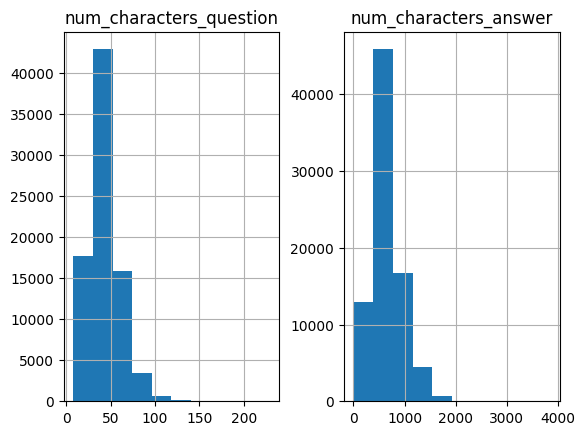

In [11]:
# Calculating the length of each cell in each column
df['num_characters_question'] = df['question'].apply(lambda x: len(x))
# df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_answer'] = df['answer'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_question', 'num_characters_answer'])

# Calculating the average
average_chars_instruction = df['num_characters_question'].mean()
# average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_answer'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
# print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

There are three different fine-tuning approaches in Ludwig:

1. **Full Fine-Tuning**:

- Involves training the entire pre-trained model on new data from scratch.
- All model layers and parameters are updated during fine-tuning.
- Can lead to high accuracy but requires a significant amount of computational resources and time.
- Runs the risk of catastrophic forgetting: occasionally, since we are updating all of the weights in the model, this process can lead to the algorithm inadvertently losing knowledge of its past tasks, i.e., the knowledge it gained during pretraining. The outcome may vary, with the algorithm experiencing heightened error margins in some cases, while in others, it might completely erase the memory of a specific task leading to terrible performance.
- Best suited when the target task is significantly different from the original pre-training task.

2. **Parameter Efficient Fine-Tuning (PEFT), e.g. LoRA**:

- Focuses on updating only a subset of the model's parameters.
- Often involves freezing certain layers or parts of the model to avoid catastrophic forgetting, or inserting additional layers that are trainable while keeping the original model's weights frozen.
- Can result in faster fine-tuning with fewer computational resources, but might sacrifice some accuracy compared to full fine-tuning.
- Includes methods like LoRA, AdaLoRA and Adaption Prompt (LLaMA Adapter)
- Suitable when the new task shares similarities with the original pre-training task.

3. **Quantization-Based Fine-Tuning (QLoRA)**:

- Involves reducing the precision of model parameters (e.g., converting 32-bit floating-point values to 8-bit or 4-bit integers). This reduces the amount of CPU and GPU memory required by either 4x if using 8-bit integers, or 8x if using 4-bit integers.
- Typically, since we're changing the weights to 8 or 4 bit integers, we will lose some precision/performance.
- This can lead to reduced memory usage and faster inference on hardware with reduced precision support.
- Particularly useful when deploying models on resource-constrained devices, such as mobile phones or edge devices.


**Today, we're going to fine-tune using method 3 since we only have access to a single T4 GPU with 16GiB of GPU VRAM on Colab.** If you have more compute available, give LoRA based fine-tuning or full fine-tuning a try! Typically this requires 4 GPUs with 24GiB of GPU VRAM on a single node multi-GPU cluster and fine-tuning Deepspeeed.


To do this, the new parameters we're introducing are:

- `adapter`: The PEFT method we want to use
- `quantization`: Load the weights in int4 or int8 to reduce memory overhead.
- `trainer`: We enable the `finetune` trainer and can configure a variety of training parameters such as epochs and learning rate.

Note, there are a few additional preprocessing parameters we should set to ensure that training runs smoothly:

```yaml
preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 0
```

- Some of the examples in the dataset have long sequences, so we set a `global_max_sequence_length` of 512 to ensure that we do not OOM.
- Splits are set up such that we use all of the data for training as evaluation phases are synchronous and will take additional time. In a full training run, we recommend using setting aside some data for the test split for evaluation metrics.

In [12]:
#!pip install numba
#
#from numba import cuda
#device = cuda.get_current_device()
#device.reset()

In [14]:
# using Llama-1, just one epoch

if False:
  model = None
  clear_cache()

  qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: huggyllama/llama-7b

input_features:
  - name: question
    type: text

output_features:
  - name: answer
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### question: {question}


    ### answer:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 0

trainer:
  type: finetune
  epochs: 1
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

  model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
  results = model.train(dataset=main_df)

In [15]:
# Using Llama-2, 5 epochs

model2 = None
clear_cache()

qlora_fine_tuning_config2 = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-hf

input_features:
  - name: question
    type: text

output_features:
  - name: answer
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### question: {question}


    ### answer:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 0

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model2 = LudwigModel(config=qlora_fine_tuning_config2, logging_level=logging.INFO)
results2 = model2.train(dataset=main_df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_4                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.util

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 2500 step(s), approximately 5 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 2500 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:  20%|█▉        | 499/2500 [06:25<27:31,  1.21it/s, loss=0.0739]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  20%|██        | 500/2500 [06:26<37:06,  1.11s/it, loss=0.0896]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 500, epoch: 1
INFO:ludwig.trainers.trainer:Evaluation took 0.3510s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.1715 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     0.5632 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     1.4330 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 18523.3965 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 32001.1621 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmeas

Training:  40%|███▉      | 998/2500 [13:06<18:50,  1.33it/s, loss=0.0475]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  40%|████      | 1000/2500 [13:08<21:54,  1.14it/s, loss=0.06]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1000, epoch: 2
INFO:ludwig.trainers.trainer:Evaluation took 0.1164s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.1830 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     0.5935 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     0.9608 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 17595.0781 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 31998.2930 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmea

Training:  60%|█████▉    | 1497/2500 [19:47<12:44,  1.31it/s, loss=0.0449]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  60%|██████    | 1500/2500 [19:50<15:22,  1.08it/s, loss=0.0339]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1500, epoch: 3
INFO:ludwig.trainers.trainer:Evaluation took 0.1217s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.4152 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     0.4606 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     0.5430 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 15094.0791 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 32000.9805 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmea

Training:  80%|███████▉  | 1996/2500 [26:29<08:18,  1.01it/s, loss=0.0277]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  80%|████████  | 2000/2500 [26:34<11:17,  1.36s/it, loss=0.0634]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2000, epoch: 4
INFO:ludwig.trainers.trainer:Evaluation took 0.1082s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.2083 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     0.4301 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     1.0143 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 17007.6230 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 31411.6367 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmea

Training: 100%|█████████▉| 2495/2500 [33:15<00:04,  1.10it/s, loss=0.032]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training: 100%|██████████| 2500/2500 [33:20<00:00,  1.14s/it, loss=0.0311]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2500, epoch: 5
INFO:ludwig.trainers.trainer:Evaluation took 0.1188s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.4355 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     0.3980 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     0.4976 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 15583.1260 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 32001.0078 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmea

Training: 100%|██████████| 2500/2500 [33:21<00:00,  1.25it/s, loss=0.0311]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


#### Perform Inference

We can now use the model we fine-tuned above to make predictions on some test examples to see whether fine-tuning the large language model improve its ability to follow instructions/the tasks we're asking it to perform.

In [20]:
test_examples = pd.DataFrame([
      {
          "question":"What structure is classified as a definite lie algebra?",
          },

      {
          "question":"What type of laser is used to study infrared?",
          },
      {
          "question":"What type of detector detects photon arrival?",
          },
      {
          "question":"Can a qw be made shapeless?",
          },
      {
          "question":"Which of the following is the only finite width of quark gluon plasma bags?",
          },
      {
          "question":"Which phase is associated with a hexagon of hexagons diffraction?",
          },
      {
          "question":"Where is the companion galaxy?",
          },

])

#predictions = model.predict(test_examples)[0]
predictions = model2.predict(test_examples)[0]

#print( predictions )
#print( len(test_examples['question']), len(predictions['answer_response']) )

for input_with_prediction in zip(test_examples['question'], predictions['answer_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Generated Output: {input_with_prediction[1][0]}")
  print("\n\n")

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.33.2"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### question: what structure is classified as a definite lie algebra?

### answer:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that 

Prediction: 100%|██████████| 1/1 [00:54<00:00, 54.58s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer


Instruction: What structure is classified as a definite lie algebra?
Generated Output: a definite lie algebra is a lie algebra over a field that has a fixed basis. this means that the lie algebra has a set of generators that satisfy a set of defining relations, and these relations are independent of the chosen basis. the structure of a definite lie algebra is fully determined by the structure of its basis and the defining relations.



Instruction: What type of laser is used to study infrared?
Generated Output: the most commonly used lasers for infrared studies are near-infrared lasers, which operate at wavelengths between 700 nm and 1000 nm. these lasers are used in a variety of infrared applications, including spectroscopy, imaging, and remote sensing.



Instruction: What type of detector detects photon arrival?
Generated Output: a photon detector that is commonly used to detect the arrival of photons is a photomultiplier. it converts the energy of a single photon into an electrical

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


#### **Observations From QLoRA Fine-Tuning** 🔎
- Even when we just fine-tune the model on 100 examples from our dataset (which only takes about 4 minutes), it significantly improves the model on our task 🔥
- The answers are not perfect when we just use 100 examples, but if we inspect the *logic* in the response, we can see that it is 95% of the way there. This is SIGNIFICANTLY better than before - there is no repetition and the actual code aspects of the answers are all correct.
- The partial errors such as `sierp` instead of `arrray` etc indicate that we need to train on a larger amount of data for the model to better learn how to follow instructions and not make these kinds of mistakes.

If you're looking for a managed solution to handle all of the hassle of figuring out the right compute for your fine-tuning task, ensuring that they always succeed without CPU or GPU out-of-memory errors, and be able to rapidly deploy them for fast real-time inference, check out [Predibase](https://www.predibase.com/).

In [ ]:
# upload the model
# !ludwig upload hf_hub --repo_id mflechl/math_physics_50k --model_path /content/results/api_experiment_run

In [ ]:
# without quantization and LoRa

# from peft import PeftModel, PeftConfig
# from transformers import AutoModelForCausalLM

# config = PeftConfig.from_pretrained("arnavgrg/codealpaca_v3")
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")
# model = PeftModel.from_pretrained(model, "arnavgrg/codealpaca_v3")